# Noções de IA - Trabalho Final - Deep Learning for Chess
##### Integrantes:
- Lucas Corrêa Boaventura           - 211038262
- Alexandre Castanho Sampaio Rocha  - 211027536

## Bibliotecas

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import chess
import pandas as pd
import numpy as np
import pickle
from random import randint
from IPython.display import clear_output
import chess.engine
engine = chess.engine.SimpleEngine.popen_uci("stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2")
%load_ext skip_kernel_extension

## Dados para trabalhar com um Tabuleiro

#### Funções

['PAWN', 'KNIGHT', 'BISHOP', 'ROOK', 'QUEEN', 'KING'] 
 ['BLACK', 'WHITE'] 
 ['p', 'n', 'b', 'r', 'q', 'k']


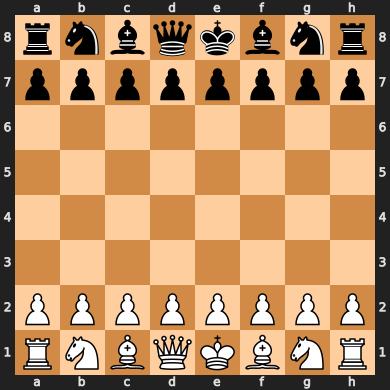

In [2]:
def getPieceMaskBoard(piece, color):
    maps = chess.Board().pieces_mask(piece, color)
    maps = list(bin(maps)[2:])
    return np.reshape(np.array([0 for _ in range(64-len(maps))]+maps, dtype=np.int8), (8, 8))[:,::-1]

def getBoard(board:list, piece:str, repr:str, color=0) -> chess.Board:
    fen=''
    for i in range(8):
        count = 0
        for j in range(8):
            v = board[i][j]
            if v == 0:
                count += 1
            else:
                if count != 0:
                    fen += str(count)
                    count = 0
                if repr == 'single': fen += [piece if color==0 else piece.upper()][0]
                elif repr == 'double': fen += [piece if v < 0 else piece.upper()][0]
        if count != 0 :
            fen += str(count)
        fen+='/'
    return chess.Board(fen[:-1])

def getSquareName(position:list) -> str: # position deve ser 'ONE-HOT', apenas uma peça
    position = position[:,::-1].flatten()
    square = 63 - list(position).index(1)
    return chess.square_name(square)

pieces_names = [piece.upper() for piece in chess.PIECE_NAMES[1:]]
pieces_colors = [color.upper() for color in chess.COLOR_NAMES]
pieces_symbols = chess.PIECE_SYMBOLS[1:]
print(pieces_names,'\n',
      pieces_colors,'\n',
      pieces_symbols
)
chess.Board()

#### 12 Matrizes 

In [3]:
data = np.array([[[0 for _ in range(8)] for _ in range(8)] for _ in range(12)], dtype=np.int8)

for i in range(len(pieces_colors)):
    for j in range(len(pieces_names)):
        data[6*i+j] = getPieceMaskBoard(getattr(chess, pieces_names[j]), getattr(chess, pieces_colors[i]))
        
for i in range(2):
    for j in range(6):
        display(data[6*i+j],pieces_symbols[j],'single',i)

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

'p'

'single'

0

array([[0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

'n'

'single'

0

array([[0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

'b'

'single'

0

array([[1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

'r'

'single'

0

array([[0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

'q'

'single'

0

array([[0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

'k'

'single'

0

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

'p'

'single'

1

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0]], dtype=int8)

'n'

'single'

1

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0]], dtype=int8)

'b'

'single'

1

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1]], dtype=int8)

'r'

'single'

1

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0]], dtype=int8)

'q'

'single'

1

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8)

'k'

'single'

1

#### 6 Matrizes sem pesos e pretas negativas

In [4]:
#data = np.array([[[0 for _ in range(8)] for _ in range(8)] for _ in range(6)], dtype=np.int8)
#for i in range(len(pieces_names)):
#        data[i] = getPieceMaskBoard(getattr(chess, pieces_names[i]), getattr(chess, pieces_colors[1])) - getPieceMaskBoard(getattr(chess, pieces_names[i]), getattr(chess, pieces_colors[0]))
#
#board = getBoard(data[0],pieces_symbols[0],'double')
#board.push_uci('e2e3')
#display(board)
#
#for i in range(6):
#        display(getBoard(data[i],pieces_symbols[i],'double'))

#### 1 Matriz com pesos e pretas negativas

In [5]:
class Board(chess.Board):
    PIECES_SYMBOLS = dict(zip([-1,1,-2,2,-3,3,-5,5,-9,9,-38,38], ['p', 'P', 'n', 'N', 'b', 'B', 'r', 'R', 'q', 'Q', 'k', 'K'] ))
    PIECES_VALUES = dict(zip(['p', 'P', 'n', 'N', 'b', 'B', 'r', 'R', 'q', 'Q', 'k', 'K'], [-1,1,-2,2,-3,3,-5,5,-9,9,-38,38]))

    def __init__(self, boardMatrix:list=None, fenpos:str="", turn:str='w') -> chess.Board:
        if boardMatrix is None:
            if fenpos == "":
                super().__init__()
            else:
                super().__init__(fenpos)
        else:
            fen=''
            for i in range(8):
                count = 0
                for j in range(8):
                    v = boardMatrix[i][j]
                    if v == 0:
                        count += 1
                    else:
                        if count != 0:
                            fen += str(count)
                            count = 0
                        fen += self.PIECES_SYMBOLS[v]
                if count != 0 :
                    fen += str(count)
                fen+='/'
            fen = fen[:-1] + ' ' + turn
            super().__init__(fen)

    def show(self):
        return display(self)
    
    def getMatrix(self) -> list:
        boardMatrix = np.array([[0 for _ in range(8)] for _ in range(8)])
        i,j = 0,0
        for p in self.fen().split()[0]:
            if p == '/':
                j = 0
                i += 1
            elif p.isnumeric():
                for _ in range(int(p)):
                    j += 1
                    pass
            else:
                boardMatrix[i][j] = Board.PIECES_VALUES[p]
                j += 1
        return boardMatrix
    
    def _getPieceMaskBoard(self, piece, color):
        maps = self.pieces_mask(piece, color)
        maps = list(bin(maps)[2:])
        return np.reshape(np.array([0 for _ in range(64-len(maps))]+maps, dtype=np.int8), (8, 8))[:,::-1]
    
    def get12Matrix(self) -> np.array:
        data = np.array([[[0 for _ in range(8)] for _ in range(8)] for _ in range(12)], dtype=np.int8)

        for i in range(len(pieces_colors)):
            for j in range(len(pieces_names)):
                data[6*i+j] = self._getPieceMaskBoard(getattr(chess, pieces_names[j]), getattr(chess, pieces_colors[i]))
                
        return data

board = Board()
board.getMatrix()

array([[ -5,  -2,  -3,  -9, -38,  -3,  -2,  -5],
       [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   1,   1,   1,   1,   1,   1,   1],
       [  5,   2,   3,   9,  38,   3,   2,   5]])

### Dados de treino e validação

#### Analisar para Brancas e Pretas

##### Tentar carregar database já compilado

In [6]:
try:
    with open('./objs/database.pkl', 'rb') as arq:
        database = pickle.load(arq)
        train_ds = database[0]
        train_y = database[1]
        val_ds = database[2]
        val_y = database[3]
        skip_cell = True                 
except FileNotFoundError:
    skip_cell = False

##### Database

In [7]:
%%skip $skip_cell

train_ds = []
train_y = []
val_ds = []
val_y = []
with open('./objs/jogos_avaliados4.txt') as arq:
    jogos = arq.readlines()
    lenght = len(jogos)
    split = .8
    for jogo in jogos[:int(split*lenght)]:
        jogo = jogo.split(' ')
        if jogo[-1] != 'None\n':
            aval = int(jogo[-1]) / 100
            pos = jogo[0]
            game = Board(fenpos=pos).getMatrix()
            game = np.reshape(game, (1, 8, 8))
            train_ds.append(game)
            train_y.append(aval)
    for jogo in jogos[int(split*lenght):]:
        jogo = jogo.split(' ')
        if jogo[-1] != 'None\n':
            aval = int(jogo[-1]) / 100
            pos = jogo[0]
            game = Board(fenpos=pos).getMatrix()
            game = np.reshape(game, (1, 8, 8))
            val_ds.append(game)
            val_y.append(aval)


train_ds = np.stack(train_ds)
train_y = np.stack(train_y)
val_ds = np.stack(val_ds)
val_y = np.stack(val_y)

train_ds.shape,train_y.shape,val_ds.shape,val_y.shape

##### Normalização

In [8]:
%%skip $skip_cell

train_max = np.abs(train_y).max()
val_max = np.abs(val_y).max()
train_y = train_y / train_max / 2 + 0.5
val_y = val_y / val_max / 2 + 0.5

database = [train_ds,train_y,val_ds,val_y]

with open('./objs/database.pkl', 'wb') as file:
    pickle.dump(database, file)

train_ds.shape,train_y.shape,val_ds.shape,val_y.shape

#### Analisar apenas Brancas

##### Tentar carregar database já compilado

In [9]:
try:
    with open('./objs/databaseForWhite.pkl', 'rb') as arq:
        databaseForWhite = pickle.load(arq)
        train_ds = database[0]
        train_y = database[1]
        val_ds = database[2]
        val_y = database[3]
        skip_cell = True                 
except FileNotFoundError:
    skip_cell = False

##### Database

In [10]:
%%skip $skip_cell

train_ds = []
train_y = []
val_ds = []
val_y = []
with open('./objs/jogos_avaliados4.txt') as arq:
    jogos = arq.readlines()
    lenght = len(jogos)
    split = .8
    for jogo in jogos[:int(split*lenght)]:
        jogo = jogo.split(' ')
        if jogo[-1] != 'None\n':
            aval = int(jogo[-1]) / 100
            pos = jogo[0]
            game = Board(fenpos=pos).getMatrix()
            if jogo[1] == 'b':
                game = (-1)*game
                aval = (-1)*aval
            game = np.reshape(game, (1, 8, 8))
            train_ds.append(game)
            train_y.append(aval)
    for jogo in jogos[int(split*lenght):]:
        jogo = jogo.split(' ')
        if jogo[-1] != 'None\n':
            aval = int(jogo[-1]) / 100
            pos = jogo[0]
            game = Board(fenpos=pos).getMatrix()
            if jogo[1] == 'b':
                game = (-1)*game
                aval = (-1)*aval
            game = np.reshape(game, (1, 8, 8))
            val_ds.append(game)
            val_y.append(aval)


train_ds = np.stack(train_ds)
train_y = np.stack(train_y)
val_ds = np.stack(val_ds)
val_y = np.stack(val_y)

train_ds.shape,train_y.shape,val_ds.shape,val_y.shape

##### Normalização

In [11]:
%%skip $skip_cell

train_max = np.abs(train_y).max()
val_max = np.abs(val_y).max()
train_y = train_y / train_max / 2 + 0.5
val_y = val_y / val_max / 2 + 0.5

databaseForWhite = [train_ds,train_y,val_ds,val_y]

with open('./objs/databaseForWhite.pkl', 'wb') as file:
    pickle.dump(databaseForWhite, file)

#### Analisar apenas Pretas

##### Tentar carregar database já compilado

In [12]:
try:
    with open('./objs/databaseForBlack.pkl', 'rb') as arq:
        databaseForBlack = pickle.load(arq)
        train_ds = database[0]
        train_y = database[1]
        val_ds = database[2]
        val_y = database[3]
        skip_cell = True                 
except FileNotFoundError:
    skip_cell = False

##### Database

In [13]:
%%skip $skip_cell

train_ds = []
train_y = []
val_ds = []
val_y = []
with open('./objs/jogos_avaliados4.txt') as arq:
    jogos = arq.readlines()
    lenght = len(jogos)
    split = .8
    for jogo in jogos[:int(split*lenght)]:
        jogo = jogo.split(' ')
        if jogo[-1] != 'None\n':
            aval = int(jogo[-1]) / 100
            pos = jogo[0]
            game = Board(fenpos=pos).getMatrix()
            if jogo[1] == 'w':
                game = (-1)*game
                aval = (-1)*aval
            game = np.reshape(game, (1, 8, 8))
            train_ds.append(game)
            train_y.append(aval)
    for jogo in jogos[int(split*lenght):]:
        jogo = jogo.split(' ')
        if jogo[-1] != 'None\n':
            aval = int(jogo[-1]) / 100
            pos = jogo[0]
            game = Board(fenpos=pos).getMatrix()
            if jogo[1] == 'w':
                game = (-1)*game
                aval = (-1)*aval
            game = np.reshape(game, (1, 8, 8))
            val_ds.append(game)
            val_y.append(aval)


train_ds = np.stack(train_ds)
train_y = np.stack(train_y)
val_ds = np.stack(val_ds)
val_y = np.stack(val_y)

train_ds.shape,train_y.shape,val_ds.shape,val_y.shape

##### Normalização

In [14]:
%%skip $skip_cell

train_max = np.abs(train_y).max()
val_max = np.abs(val_y).max()
train_y = train_y / train_max / 2 + 0.5
val_y = val_y / val_max / 2 + 0.5

databaseForBlack = [train_ds,train_y,val_ds,val_y]

with open('./objs/databaseForBlack.pkl', 'wb') as file:
    pickle.dump(databaseForBlack, file)

## Modelo

#### Funções

In [15]:
def block(x, filters, kernelsize):
    fx = layers.Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.Conv2D(filters, kernelsize, padding='same')(fx)
    out = layers.Add()([x,fx])
    out = layers.ReLU()(out)
    out = layers.BatchNormalization()(out)

    return out

def modelo(num_blocks, filters, kernelsize):
    input_shape = layers.Input(shape=(1, 8, 8))
    
    x = input_shape
    x = layers.Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    for _ in range(num_blocks):
        x = block(x, filters, kernelsize)
        
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    return tf.keras.models.Model(inputs=input_shape, outputs=x)

## Treinamento

### Modelo com 2 Blocos de Convolução

#### Tentar carregar modelo já treinado

In [16]:
try:
    with open('./objs/model2Conv.pkl', 'rb') as arq:
        model2Conv = pickle.load(arq)
        skip_cell = True                 
except FileNotFoundError:
    skip_cell = False

#### Regularização EarlyStopping

In [17]:
%%skip $skip_cell

with open('./objs/database.pkl', 'rb') as arq:
    database = pickle.load(arq)
    train_ds = database[0]
    train_y = database[1]
    val_ds = database[2]
    val_y = database[3]

model2Conv = modelo(2, 32, 3)
model2Conv.compile(optimizer='adam', loss='mse')

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=0.00001)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=10)

model2Conv.fit(train_ds, train_y, batch_size=1024, epochs=100, verbose=1, validation_split=0.1, 
               callbacks=[es, rp])

with open('./objs/model2Conv.pkl', 'wb') as file:
    pickle.dump(model2Conv, file)

Epoch 1/100
1194/1194 [==============================] - 42s 34ms/step - loss: 0.0016 - val_loss: 8.7143e-04 - lr: 0.0010
Epoch 2/100
1194/1194 [==============================] - 40s 33ms/step - loss: 5.8867e-04 - val_loss: 6.2008e-04 - lr: 0.0010
Epoch 3/100
1194/1194 [==============================] - 40s 33ms/step - loss: 4.7846e-04 - val_loss: 4.5866e-04 - lr: 0.0010
Epoch 4/100
1194/1194 [==============================] - 40s 33ms/step - loss: 4.4899e-04 - val_loss: 4.2178e-04 - lr: 0.0010
Epoch 5/100
1194/1194 [==============================] - 40s 34ms/step - loss: 4.3555e-04 - val_loss: 4.6733e-04 - lr: 0.0010
Epoch 6/100
1194/1194 [==============================] - 41s 35ms/step - loss: 4.2443e-04 - val_loss: 4.4091e-04 - lr: 0.0010
Epoch 7/100
1194/1194 [==============================] - 43s 36ms/step - loss: 4.1936e-04 - val_loss: 4.2076e-04 - lr: 0.0010
Epoch 8/100
1194/1194 [==============================] - 42s 35ms/step - loss: 4.1227e-04 - val_loss: 4.0829e-04 - lr: 0.0

#### Avaliação

In [18]:
loss = model2Conv.evaluate(val_ds, val_y)

10605/10605 [==============================] - 13s 1ms/step - loss: 5.5145e-04


### Modelo com 3 Conv

#### Tentar carregar modelo já treinado

In [19]:
try:
    with open('./objs/model3Conv.pkl', 'rb') as arq:
        model3Conv = pickle.load(arq)
        skip_cell = True                 
except FileNotFoundError:
    skip_cell = False

#### Regularização EarlyStopping

In [20]:
%%skip $skip_cell

with open('./objs/database.pkl', 'rb') as arq:
    database = pickle.load(arq)
    train_ds = database[0]
    train_y = database[1]
    val_ds = database[2]
    val_y = database[3]

model3Conv = modelo(3, 32, 3)
model3Conv.compile(optimizer='adam', loss='mse')

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=0.00001)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=10)

model3Conv.fit(train_ds, train_y, batch_size=1024, epochs=100, verbose=1, validation_split=0.1, 
               callbacks=[es, rp])

with open('./objs/model3Conv.pkl', 'wb') as file:
    pickle.dump(model3Conv, file)

Epoch 1/100
1194/1194 [==============================] - 59s 48ms/step - loss: 0.0013 - val_loss: 6.3038e-04 - lr: 0.0010
Epoch 2/100
1194/1194 [==============================] - 58s 48ms/step - loss: 5.0248e-04 - val_loss: 4.6300e-04 - lr: 0.0010
Epoch 3/100
1194/1194 [==============================] - 57s 48ms/step - loss: 4.5537e-04 - val_loss: 4.8796e-04 - lr: 0.0010
Epoch 4/100
1194/1194 [==============================] - 56s 47ms/step - loss: 4.3616e-04 - val_loss: 5.1722e-04 - lr: 0.0010
Epoch 5/100
1194/1194 [==============================] - 58s 48ms/step - loss: 4.2881e-04 - val_loss: 4.4222e-04 - lr: 0.0010
Epoch 6/100
1194/1194 [==============================] - 58s 49ms/step - loss: 4.2081e-04 - val_loss: 4.1268e-04 - lr: 0.0010
Epoch 7/100
1194/1194 [==============================] - 57s 48ms/step - loss: 4.1603e-04 - val_loss: 4.1856e-04 - lr: 0.0010
Epoch 8/100
1194/1194 [==============================] - 58s 48ms/step - loss: 4.0922e-04 - val_loss: 4.1234e-04 - lr: 0.0

#### Avaliação

In [21]:
loss = model3Conv.evaluate(val_ds, val_y)

10605/10605 [==============================] - 15s 1ms/step - loss: 5.4565e-04


### Modelo com 2 Conv, mas database invertendo sinal (analisar apenas "brancas")

#### Tentar carregar modelo já treinado

In [22]:
try:
    with open('./objs/model2Conv_changeSignal.pkl', 'rb') as arq:
        model2Conv_changeSignal = pickle.load(arq)
        skip_cell = True                 
except FileNotFoundError:
    skip_cell = False

#### Regularização EarlyStopping

In [23]:
%%skip $skip_cell

with open('./objs/databaseForWhite.pkl', 'rb') as arq:
    databaseForWhite = pickle.load(arq)
    train_ds = databaseForWhite[0]
    train_y = databaseForWhite[1]
    val_ds = databaseForWhite[2]
    val_y = databaseForWhite[3]


model2Conv_changeSignal = modelo(2, 32, 3)
model2Conv_changeSignal.compile(optimizer='adam', loss='mse')

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=0.00001)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=10)

model2Conv_changeSignal.fit(train_ds, train_y, batch_size=1024, epochs=100, verbose=1, validation_split=0.1, 
               callbacks=[es, rp])

with open('./objs/model2Conv_changeSignal.pkl', 'wb') as file:
    pickle.dump(model2Conv_changeSignal, file)

#### Avaliação

In [24]:
loss = model2Conv_changeSignal.evaluate(val_ds, val_y)

10605/10605 [==============================] - 13s 1ms/step - loss: 5.8710e-04


### Modelo com 2 Conv, mas database invertendo sinal (analisar apenas "pretas")

#### Tentar carregar modelo já treinado

In [25]:
try:
    with open('./objs/model2Conv_changeSignalBlack.pkl', 'rb') as arq:
        model2Conv_changeSignalBlack = pickle.load(arq)
        skip_cell = True                 
except FileNotFoundError:
    skip_cell = False

#### Regularização EarlyStopping

In [26]:
%%skip $skip_cell

with open('./objs/databaseForBlack.pkl', 'rb') as arq:
    databaseForBlack = pickle.load(arq)
    train_ds = databaseForBlack[0]
    train_y = databaseForBlack[1]
    val_ds = databaseForBlack[2]
    val_y = databaseForBlack[3]


model2Conv_changeSignalBlack = modelo(2, 32, 3)
model2Conv_changeSignalBlack.compile(optimizer='adam', loss='mse')

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=0.00001)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=10)

model2Conv_changeSignalBlack.fit(train_ds, train_y, batch_size=1024, epochs=100, verbose=1, validation_split=0.1, 
               callbacks=[es, rp])

with open('./objs/model2Conv_changeSignalBlack.pkl', 'wb') as file:
    pickle.dump(model2Conv_changeSignalBlack, file)

#### Avaliação

In [27]:
loss = model2Conv_changeSignalBlack.evaluate(val_ds, val_y)

10605/10605 [==============================] - 13s 1ms/step - loss: 6.0139e-04


### Modelo com 3 Conv, mas database invertendo sinal (analisar apenas "brancas")

#### Tentar carregar modelo já treinado

In [28]:
try:
    with open('./objs/model3Conv_changeSignal.pkl', 'rb') as arq:
        model3Conv_changeSignal = pickle.load(arq)
        skip_cell = True                 
except FileNotFoundError:
    skip_cell = False

#### Regularização EarlyStopping

In [29]:
%%skip $skip_cell

with open('./objs/databaseForWhite.pkl', 'rb') as arq:
        databaseForWhite = pickle.load(arq)
        train_ds = databaseForWhite[0]
        train_y = databaseForWhite[1]
        val_ds = databaseForWhite[2]
        val_y = databaseForWhite[3]


model3Conv_changeSignal = modelo(3, 32, 3)
model3Conv_changeSignal.compile(optimizer='adam', loss='mse')

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=0.00001)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=10)

model3Conv_changeSignal.fit(train_ds, train_y, batch_size=1024, epochs=100, verbose=1, validation_split=0.1, 
               callbacks=[es, rp])

with open('./objs/model3Conv_changeSignal.pkl', 'wb') as file:
    pickle.dump(model3Conv_changeSignal, file)

#### Avaliação

In [30]:
loss = model3Conv_changeSignal.evaluate(val_ds, val_y)

10605/10605 [==============================] - 16s 1ms/step - loss: 6.2022e-04


### Modelo com 3 Conv, mas database invertendo sinal (analisar apenas "pretas")

#### Tentar carregar modelo já treinado

In [31]:
try:
    with open('./objs/model3Conv_changeSignalBlack.pkl', 'rb') as arq:
        model3Conv_changeSignalBlack = pickle.load(arq)
        skip_cell = True                 
except FileNotFoundError:
    skip_cell = False

#### Regularização EarlyStopping

In [32]:
%%skip $skip_cell

with open('./objs/databaseForBlack.pkl', 'rb') as arq:
        databaseForBlack = pickle.load(arq)
        train_ds = databaseForBlack[0]
        train_y = databaseForBlack[1]
        val_ds = databaseForBlack[2]
        val_y = databaseForBlack[3]


model3Conv_changeSignalBlack = modelo(3, 32, 3)
model3Conv_changeSignalBlack.compile(optimizer='adam', loss='mse')

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=0.00001)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=10)

model3Conv_changeSignalBlack.fit(train_ds, train_y, batch_size=1024, epochs=100, verbose=1, validation_split=0.1, 
               callbacks=[es, rp])

with open('./objs/model3Conv_changeSignalBlack.pkl', 'wb') as file:
    pickle.dump(model3Conv_changeSignalBlack, file)

#### Avaliação

In [33]:
loss = model3Conv_changeSignalBlack.evaluate(val_ds, val_y)

10605/10605 [==============================] - 15s 1ms/step - loss: 6.0112e-04


## Comparação

### Funções

#### Pegar melhores 5 movimentos do StockFish

In [34]:
def showStockFishBestMoves(board:Board) -> None:
    analysed_variations = engine.analyse(board, chess.engine.Limit(time=0.01), multipv=5)
    top_five_moves = [variation["pv"][0].uci() for variation in analysed_variations]
    print(top_five_moves)

#### Pegar o movimento que gera a melhor posição

In [35]:
def getWhiteBestMove(position:Board, model:tf.keras.models.Model) -> chess.Move:
    new_positions = []
    possible_moves = [move.uci() for move in position.generate_legal_moves()]
    for move in possible_moves:
        position.push_uci(move)
        new_position = position.getMatrix() # inverter cores
        new_position = np.reshape(new_position, (1, 8, 8))
        new_positions.append(new_position)
        position.pop()
    new_positions = np.stack(new_positions)
    return possible_moves[np.array(model(new_positions)).argmax()]

def getBlackBestMove(position:Board, model:tf.keras.models.Model) -> chess.Move:
    new_positions = []
    possible_moves = [move.uci() for move in position.generate_legal_moves()]
    for move in possible_moves:
        position.push_uci(move)
        new_position = position.getMatrix()
        new_position = np.reshape(new_position, (1, 8, 8))
        new_positions.append(new_position)
        position.pop()
    new_positions = np.stack(new_positions)
    return possible_moves[np.array(model(new_positions)).argmin()]

def getNewMoves(position:Board) -> np.stack:
    new_positions = []
    possible_moves = [move.uci() for move in position.generate_legal_moves()]
    for move in possible_moves:
        position.push_uci(move)
        new_position = position.getMatrix() # inverter cores
        new_position = np.reshape(new_position, (1, 8, 8))
        new_positions.append(new_position)
        position.pop()
    return np.stack(new_positions)


def getTwoMovesForWhite(position:Board, model:tf.keras.models.Model):
    best_move = getWhiteBestMove(position, model)
    position.push_uci(best_move)
    position.show()
    position = Board(position.getMatrix(), turn='b')
    
    best_move = getBlackBestMove(position, model)
    position.push_uci(best_move)
    position.show()
    position = Board(position.getMatrix(), turn='w')

getNewMoves(Board())[0]


array([[[ -5,  -2,  -3,  -9, -38,  -3,  -2,  -5],
        [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   2],
        [  1,   1,   1,   1,   1,   1,   1,   1],
        [  5,   2,   3,   9,  38,   3,   0,   5]]])

### Análise

#### Jogar pelas brancas

In [36]:
position = Board()
showStockFishBestMoves(position)

best_move = print("Model2Conv: ", getWhiteBestMove(position, model2Conv))
best_move = print("Model3Conv: ", getWhiteBestMove(position, model3Conv))
best_move = print("model2Conv_changeSignal: ", getWhiteBestMove(position, model2Conv_changeSignal))
best_move = print("model2Conv_changeSignalBlack: ", getWhiteBestMove(position, model2Conv_changeSignalBlack))
best_move = print("model3Conv_changeSignal: ", getWhiteBestMove(position, model3Conv_changeSignal))
best_move = print("model3Conv_changeSignalBlack: ", getWhiteBestMove(position, model3Conv_changeSignalBlack))

['e2e4', 'd2d4', 'g1f3', 'b1c3', 'a2a3']
Model2Conv:  e2e4
Model3Conv:  b1c3
model2Conv_changeSignal:  b1c3
model2Conv_changeSignalBlack:  b1c3
model3Conv_changeSignal:  e2e4
model3Conv_changeSignalBlack:  b1c3


#### Jogar pela pretas

In [37]:
position = Board(fenpos="rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b") # e2e4

showStockFishBestMoves(position)


best_move = print("Model2Conv: ", getBlackBestMove(position, model2Conv))
best_move = print("Model3Conv: ", getBlackBestMove(position, model3Conv))
best_move = print("model2Conv_changeSignal: ", getBlackBestMove(position, model2Conv_changeSignal))
best_move = print("model2Conv_changeSignalBlack: ", getBlackBestMove(position, model2Conv_changeSignalBlack))
best_move = print("model3Conv_changeSignal: ", getBlackBestMove(position, model3Conv_changeSignal))
best_move = print("model3Conv_changeSignalBlack: ", getBlackBestMove(position, model3Conv_changeSignalBlack))

['e7e5', 'd7d6', 'e7e6', 'c7c5', 'c7c6']
Model2Conv:  e7e5
Model3Conv:  c7c6
model2Conv_changeSignal:  b8c6
model2Conv_changeSignalBlack:  e7e5


model3Conv_changeSignal:  b8c6
model3Conv_changeSignalBlack:  b8c6


## Aplicação

#### Jogando contra o usuário

In [38]:
def letsPlayAGameWhite(model:tf.keras.models.Model) -> None:
    position = Board()
    while(not position.is_checkmate()):
        best_move = getWhiteBestMove(position, model)
        position.push_uci(best_move)
        position.show()
        position = Board(position.getMatrix(), turn='b')
        
        clear_output(wait=True)
        
        user_move = ""
        user_move = input("Faça seu movimento(ex: e2e4): ")
        while(True):
            try:
                position.push_uci(user_move)
                break
            except:
                user_move = input("Movimento errado! Faça outro(ESC/ENTER para parar de jogar): ")
                if user_move == "": return
        position.show()
        position = Board(position.getMatrix(), turn='w')

def letsPlayAGameBlack(model:tf.keras.models.Model) -> None:
    position = Board()
    while(not position.is_checkmate()):
        user_move = ""
        user_move = input("Faça seu movimento(ex: e2e4): ")
        while(True):
            try:
                position.push_uci(user_move)
                break
            except:
                user_move = input("Movimento errado! Faça outro(ESC/ENTER para parar de jogar): ")
                if user_move == "": return
        position.show()
        position = Board(position.getMatrix(), turn='b')

        clear_output(wait=True)

        best_move = getBlackBestMove(position, model)
        position.push_uci(best_move)
        position.show()
        position = Board(position.getMatrix(), turn='w')

## Árvore de Decisão

In [39]:
class TreeNode:
    def __init__(self, key):
        self.key = key
        self.children = []

class GeneralTree:
    def __init__(self):
        self.root = None

    def insert(self, parent_key, key):
        new_node = TreeNode(key)
        if not self.root:
            self.root = new_node
        else:
            parent_node = self._find_node(self.root, parent_key)
            if parent_node:
                parent_node.children.append(new_node)
            else:
                print(f"Parent with key {parent_key} not found. Node {key} not inserted.")

    def _find_node(self, current_node, key):
        if current_node.key == key:
            return current_node
        for child in current_node.children:
            result = self._find_node(child, key)
            if result:
                return result
        return None

    def bottom_up_search(self, key):
        return self._bottom_up_search(self.root, key)

    def _bottom_up_search(self, current_node, key):
        if current_node is None:
            return None
        
        # Check if the current node has a child with the given key
        for child in current_node.children:
            if child.key == key:
                return child

        # Perform bottom-up search on the children
        for child in current_node.children:
            result = self._bottom_up_search(child, key)
            if result:
                return result

        return None

# Example Usage:
tree = GeneralTree()
tree.insert(None, 1)  # Inserting root node
tree.insert(1, 2)     # Inserting a child under node 1
tree.insert(1, 3)     # Inserting another child under node 1
tree.insert(2, 4)     # Inserting a child under node 2

result = tree.bottom_up_search(5)
if result:
    print(f"Node with value 4 found in the tree.")
else:
    print(f"Node with value 4 not found in the tree.")

    


Node with value 4 not found in the tree.


In [40]:
def getNewMoves(position:Board) -> np.stack:
    new_positions = []
    possible_moves = [move.uci() for move in position.generate_legal_moves()]
    for move in possible_moves:
        position.push_uci(move)
        new_position = position.getMatrix() # inverter cores
        new_position = np.reshape(new_position, (1, 8, 8))
        new_positions.append(new_position)
        position.pop()
    return np.stack(new_positions)

class MovesAhead():
    def __init__(self, position:Board, depth:int) -> None:
        self.last_move = np.reshape(position.getMatrix(), (1, 8, 8))
        self.turn = position.fen().split()[1]
        self.possible_moves = []
        if depth == 0 : return
        for move in getNewMoves(position):
            next_turn = 'b' if self.turn == 'w' else 'w'
            self.possible_moves.append(MovesAhead(Board(move[0], turn=next_turn), depth-1))
    def show(self):
        self.show = display(Board(self.last_move[0]))
    

def getBestMoveAheadEdition(position:Board, model:tf.keras.models.Model):
    movesTree = MovesAhead(position, 2)
    h = []
    g = []
    for oneAhead in movesTree.possible_moves:
        for twoAhead in oneAhead.possible_moves:
            h.append(twoAhead.last_move)
        g.append(oneAhead.possible_moves[np.array(model(np.array(h))).argmax()]) # pior pras pretas
        h = []
    moves = np.array([x.last_move for x in g])
    best_position = movesTree.possible_moves[np.array(model(moves)).argmax()].last_move[0]
    moveMatrix = best_position-position.getMatrix()#b1c3
    past = 63 - moveMatrix.argmin()
    future = 63 - moveMatrix.argmax()
    posicoes = {i: chr(ord('a') + i - 1) for i in range(1, 9)}
    best_move = posicoes[8-past%8]+str(past//8 +1)+posicoes[8-future%8]+str(future//8 +1)
    return best_move

In [41]:
def letsPlayAGame20(model:tf.keras.models.Model) -> None:
    position = Board()
    while(not position.is_checkmate()):
        best_move = getBestMoveAheadEdition(position, model)
        position.push_uci(best_move)
        position.show()
        position = Board(position.getMatrix(), turn='b')
        
        clear_output(wait=True)
        
        user_move = ""
        user_move = input("Faça seu movimento(ex: e2e4): ")
        while(True):
            try:
                position.push_uci(user_move)
                break
            except:
                user_move = input("Movimento errado! Faça outro(ESC/ENTER para parar de jogar): ")
                if user_move == "": return
        position.show()
        position = Board(position.getMatrix(), turn='w')

### Alpha-Beta Pruning

In [42]:
def model_eval(board, model):
    game = Board(fenpos=board.fen).getMatrix()
    game = np.reshape(game, (1, 1, 8, 8))
    return float(model(game))

def minimax(board, depth, alpha, beta, max_player):
    if depth == 0 or board.is_game_over():
        return model_eval(board, model2Conv_changeSignalBlack)
    
    if max_player:
        for move in board.generate_legal_moves():
            
            board.push_san(move)
            eval = minimax(board, depth-1, alpha, beta, False)
            board.pop()
            if eval >= beta:
                return beta
            alpha = max(alpha, eval)
        return alpha
    
    else:
        for move in board.generate_legal_moves():
            
            board.push_san(move)
            eval = minimax(board, depth-1, alpha, beta, True)
            board.pop()
            if eval <= alpha:
                return alpha
            beta = min(beta, eval)
        return beta